# Bitcoin Daily Volatility Forecast

This jupyter notebook illustrates a real use case scenario, volatility forecasting.
More specifically, we will build a GARCH (Generalized Autoregressive Conditional Heteroskedasticity) model to estimate next day BTC/USDT volatility.

A volatility forecasting model is a critical tool in finance and investment management for several reasons:

1. ### Risk Management

- **Portfolio Management**: Understanding and predicting volatility helps portfolio managers assess the risk associated with their investments. By forecasting periods of high volatility, they can adjust their portfolios to manage risk better, for example, by reducing exposure to high-risk assets or hedging with derivatives.

- **Value-at-Risk (VaR)**: Volatility forecasts are integral to calculating VaR, a widely used risk metric that estimates the maximum potential loss of a portfolio over a given time frame at a certain confidence level.

2. ### Derivative Pricing and Trading

- **Option Pricing**: Volatility is a key input in option pricing models, such as the Black-Scholes model. Accurately forecasting volatility can lead to better pricing of options and other derivative instruments.

- **Hedging Strategies**: Traders use volatility forecasts to implement dynamic hedging strategies. For instance, in delta hedging, knowing future volatility helps in determining the number of underlying assets required to offset the risk of options.

3. ### Market Timing and Strategy Development

- **Investment Strategies**: Volatility forecasts can guide investment strategies. For example, some strategies, like volatility arbitrage, directly exploit discrepancies between forecasted and implied volatility. Others may involve changing the asset allocation based on expected market conditions.

- **Market Timing**: Investors can use volatility forecasts to time the market. For instance, they might increase cash holdings during periods of expected high volatility to avoid market drawdowns.

4. ### Regulatory and Compliance Requirements

- **Capital Adequacy**: Financial institutions are required to hold a certain amount of capital against potential losses. Volatility forecasts help in determining the required capital buffers, ensuring that institutions are adequately capitalized to withstand adverse market movements.

- **Stress Testing**: Regulators require banks and other financial institutions to conduct stress tests that often use volatility forecasts to model extreme but plausible market scenarios.

5. ### Economic and Monetary Policy

- **Policy Formulation**: Central banks and policymakers monitor market volatility as an indicator of financial stability. Volatility forecasting models can aid in assessing the likelihood of financial market disruptions and the potential impact of policy decisions.

- **Macroprudential Regulation**: Volatility measures are used to monitor systemic risk in the financial system. Forecasting future volatility can help in identifying periods of elevated risk that may require regulatory intervention.

6. ### Risk-Adjusted Performance Measurement

- **Sharpe Ratio and Other Metrics**: Investors use volatility to calculate risk-adjusted performance metrics such as the Sharpe ratio. Accurate volatility forecasts improve the assessment of whether a portfolio's returns adequately compensate for its risk.

7. ### Investor Sentiment and Behavioral Insights

- **Market Sentiment Analysis**: Volatility can be a proxy for investor sentiment, with high volatility often associated with fear or uncertainty. Forecasting volatility can provide insights into market psychology, helping investors understand potential shifts in sentiment and positioning.

### Loading OHLCV Data & Calculate Volatility

To calculate volatility we will group by day 1 minute candles data available from [Binance](https://data.binance.vision).

The realized volatility for a given day is calculated using the sum of squared intraday log returns. The realized volatility for the day can be expressed as:

$$ 
\sigma_{\text{realized}} = \sqrt{\sum_{i=1}^{N} r_{i}^2}
$$

where:
- $ \sigma_{\text{realized}} $ is the realized volatility.
- $ r_{i} $ is the log return at the i-th minute.
- $ \N $ is the total number of intraday intervals in the day.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm import tqdm

pd.options.mode.chained_assignment = None

# Load data
with pd.HDFStore("Storage.h5", mode="r", complevel=0) as storage:
    df = storage["/BTCUSDT_1d_OHLCV"].copy()
    df_intraday = storage["/BTCUSDT_1m_OHLCV"].copy()

# calculate daily volatility using intraday 1 minute clandles closing data
df_intraday['Log_Return'] = np.log(df_intraday['Close'] / df_intraday['Close'].shift(1))
df_intraday["DT"] = df_intraday.index.date
df["Realized_Volatility"] = df_intraday.groupby(by="DT")['Log_Return'].apply(lambda x: np.sqrt(np.sum(x ** 2))).values

# constants for quick changes
VOL_MODEL = "GARCH"
START_TEST_FROM = "01/01/2023"
P_VALUE = 1
Q_VALUE = 3
SCALING_FACTOR = 1
MIN_TRAIN_DATA = 400
MODEL_MEAN = "constant"
MODEL_DIST = "normal"
WINDOW = 7

# Display the first few rows
df.head()

,Open,High,Low,Close,Volume,Realized_Volatility
2017-08-17 00:00:00+00:00,4261.48,4485.39,4200.74,4285.08,795.150377,0.070659
2017-08-18 00:00:00+00:00,4285.08,4371.52,3938.77,4108.37,1199.888264,0.110651
2017-08-19 00:00:00+00:00,4108.37,4184.69,3850.00,4139.98,381.309763,0.119794
2017-08-20 00:00:00+00:00,4120.98,4211.08,4032.62,4086.29,467.083022,0.074306
2017-08-21 00:00:00+00:00,4069.13,4119.62,3911.79,4016.00,691.743060,0.122274


### Exploratory Data Analysis (EDA)

We can now check a few basic information from the dataset.

In [2]:
# Check for missing values
df.isnull().sum()

Open                   0
High                   0
Low                    0
Close                  0
Volume                 0
Realized_Volatility    0
dtype: int64

In [3]:
# Summary statistics
df.describe()

,Open,High,Low,Close,Volume,Realized_Volatility
count,2545.000000,2545.000000,2545.000000,2545.000000,2545.000000,2545.000000
mean,24227.726047,24827.929804,23569.338204,24248.962118,70234.527876,0.037010
std,18947.539881,19384.790182,18460.565351,18955.367006,81782.488968,0.028071
min,3188.010000,3276.500000,2817.000000,3189.020000,228.108068,0.002536
25%,8212.490000,8429.540000,8003.160000,8212.000000,29004.071419,0.020952
50%,18809.130000,19294.840000,18184.990000,18846.620000,44719.651620,0.029019
75%,37777.350000,39167.340000,36677.000000,37780.670000,74022.424393,0.042740
max,73072.400000,73777.000000,71333.310000,73072.410000,760705.362783,0.307363


In [4]:
# Data types
df.dtypes

Open                   float64
High                   float64
Low                    float64
Close                  float64
Volume                 float64
Realized_Volatility    float64
dtype: object

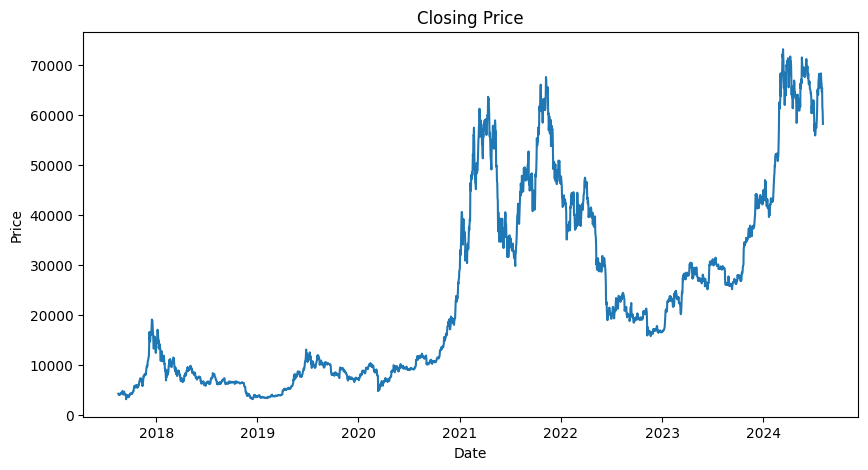

In [5]:
# Plot closing prices
plt.figure(figsize=(10,5))
plt.plot(df.index, df['Close'])
plt.title('Closing Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

### Feature Engineering

We have to ensure that the data is stationary before training a GARCH model, closing price data therefore can't be use. We will use instead the natural logarithm of daily returns instead.

In [6]:
# Calculate log returns
df['Log_Return'] = np.log(df['Close'] / df['Close'].shift(1))

# Drop missing values due to differencing
df.dropna(inplace=True)

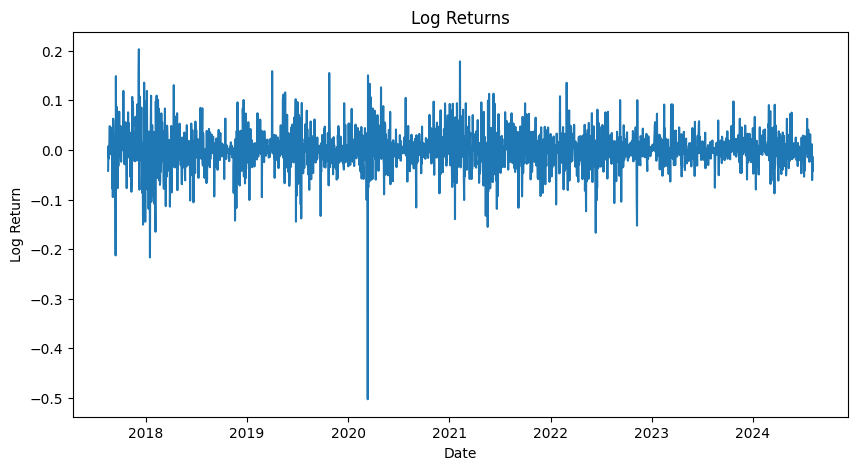

In [7]:
# Plot log returns
plt.figure(figsize=(10,5))
plt.plot(df.index, df['Log_Return'])
plt.title('Log Returns')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.show()

### Split Data for Out-Of-Sample

This ensures there is no data leakage.

In [8]:
# Split data into training and test sets
start_test_date = pd.to_datetime(START_TEST_FROM, format="%d/%m/%Y", utc=True)
train_idx = df.index < start_test_date
test_idx = df.index >= start_test_date
train_df, test_df = df.loc[train_idx, :], df.loc[test_idx, :]

### Check Stationarity

In [9]:
# ADF test
adf_test = adfuller(train_df['Log_Return'])
print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')

ADF Statistic: -30.74982762775774
p-value: 0.0


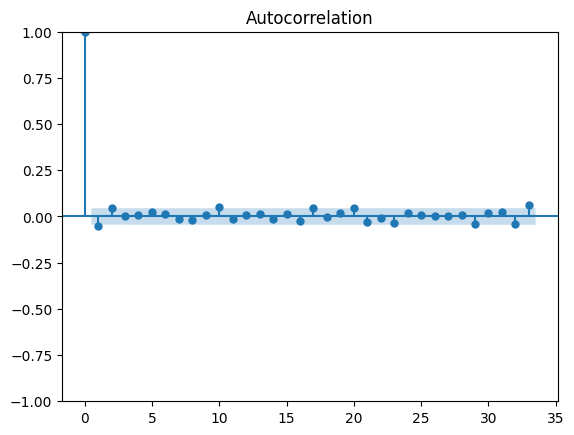

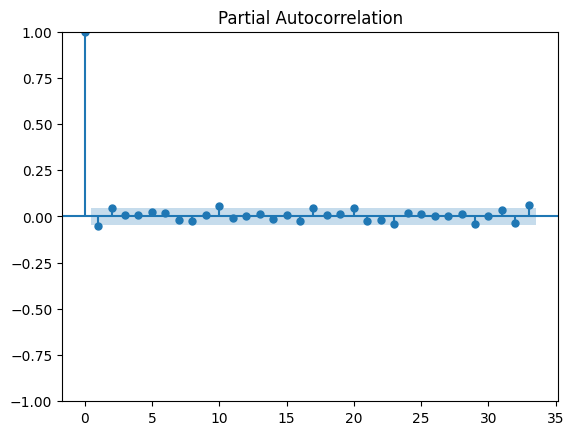

In [10]:
# ACF and PACF plots
plot_acf(train_df['Log_Return'])
plot_pacf(train_df['Log_Return'])
plt.show()

### Fitting a Preliminary GARCH Model

This will give us a first impression on how the model is performing. Later in this document we will do a rolling forecast to ensure that GARCH model is constantly updated before making the next day's forecast.

In [11]:
# Define and fit GARCH model
model = arch_model(df['Log_Return'] * SCALING_FACTOR, vol=VOL_MODEL, p=P_VALUE, q=Q_VALUE,
                   mean=MODEL_MEAN, dist=MODEL_DIST)
model_fit = model.fit(disp="off", last_obs=len(train_df))
print(model_fit.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:             Log_Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                3557.98
Distribution:                  Normal   AIC:                          -7103.96
Method:            Maximum Likelihood   BIC:                          -7070.47
                                        No. Observations:                 1962
Date:                Wed, Aug 07 2024   Df Residuals:                     1961
Time:                        13:35:09   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         1.1003e-03  8.297e-04      1.326      0.185 

/Users/davidforino/miniforge3/envs/BinanceData/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001712. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


### Model Evaluation

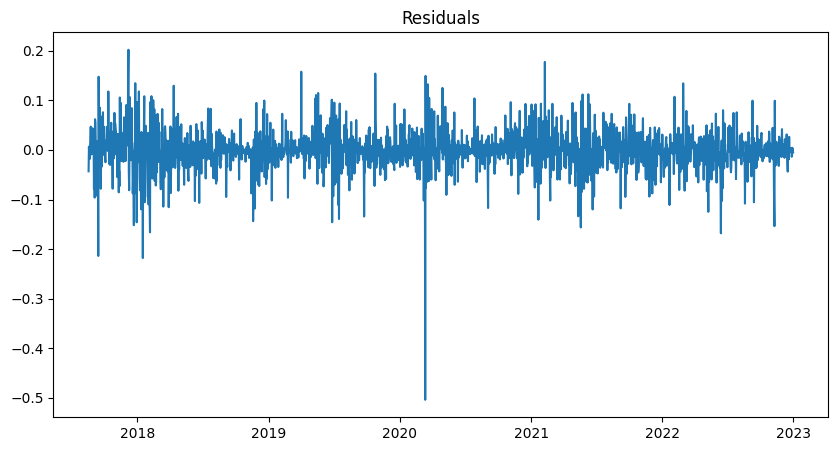

In [12]:
# Residuals analysis
plt.figure(figsize=(10,5))
plt.plot(model_fit.resid)
plt.title('Residuals')
plt.show()

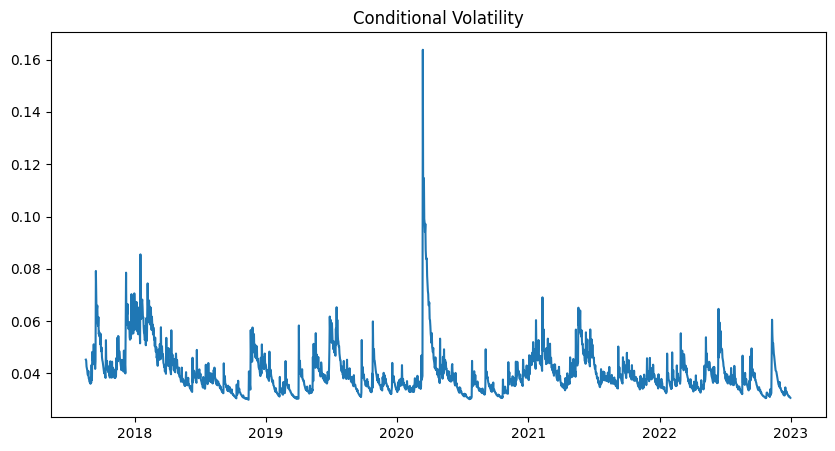

In [13]:
# Conditional volatility plot
plt.figure(figsize=(10,5))
plt.plot(model_fit.conditional_volatility)
plt.title('Conditional Volatility')
plt.show()

In [14]:
# Calculate metrics like AIC, BIC
aic = model_fit.aic
bic = model_fit.bic
print(f'AIC: {aic}')
print(f'BIC: {bic}')

AIC: -7103.961405870743
BIC: -7070.471088029991


### Forecasting & Evaluating GARCH Model

GARCH models can't forecast successfully far into the future, for this reason every time a new data point is available (new volatility at the end of the day), we have to include it into the training data and retrain the model for next day's forecast.

The function below does exactly this, in a rolling fashion, the model is trained and makes forecast for the next day. Forecasts are then returned for performance comparison later on.

In [15]:
def rolling_forecast(use_oos:bool = True) -> np.ndarray:
    rolling_forecasts = [] if use_oos else [0 for _ in range(MIN_TRAIN_DATA)]
    indices = test_df.index if use_oos else train_df.index[MIN_TRAIN_DATA:]

    # ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
    for ts in tqdm(indices):
        # GET THE DATA AT ALL PREVIOUS TIME STEPS
        ts_train = df["Log_Return"].loc[df.index <= ts]

        # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
        model = arch_model(ts_train, vol=VOL_MODEL, p=P_VALUE, q=Q_VALUE,
                           mean=MODEL_MEAN, dist=MODEL_DIST, rescale=False)
        model_fit = model.fit(disp='off', last_obs=len(ts_train)-1)

        # MAKE PREDICTION
        pred = (model_fit.forecast(horizon=1, start=len(ts_train)-1).variance.values[0][0])

        # remove scaling factor
        pred = pred / (SCALING_FACTOR ** 2)

        # APPEND TO rolling_forecasts LIST
        rolling_forecasts.append(pred)
    
    return np.array(rolling_forecasts)

In [16]:
# Convert variance to predicted volatility
train_df['Predicted_Volatility'] = np.sqrt(rolling_forecast(use_oos=False))

100%|██████████| 1562/1562 [00:31<00:00, 50.36it/s]


In [17]:
# Convert variance to predicted volatility
test_df['Predicted_Volatility'] = np.sqrt(rolling_forecast(use_oos=True))

100%|██████████| 582/582 [00:18<00:00, 31.43it/s]


In [18]:
# Calculate performance metrics
mae = mean_absolute_error(test_df['Realized_Volatility'], test_df['Predicted_Volatility'])
mse = mean_squared_error(test_df['Realized_Volatility'], test_df['Predicted_Volatility'])

print(f'MAE: {mae}')
print(f'MSE: {mse}')

MAE: 0.010237249133333766
MSE: 0.00013862224977091475


### Visualizations

After evaluating model's metrics, it's time to visualize how the model is performing.

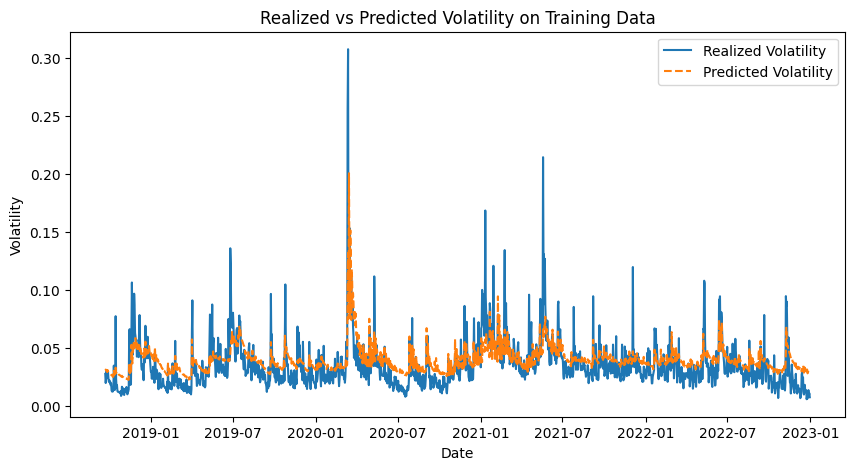

In [19]:
# remove initial data used for training
idx = train_df["Predicted_Volatility"] > 0
train_df = train_df[idx]

# Plot the actual vs predicted volatility
plt.figure(figsize=(10,5))
plt.plot(train_df.index, train_df['Realized_Volatility'], label='Realized Volatility')
plt.plot(train_df.index, train_df['Predicted_Volatility'], label='Predicted Volatility', linestyle='--')
plt.title('Realized vs Predicted Volatility on Training Data')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()

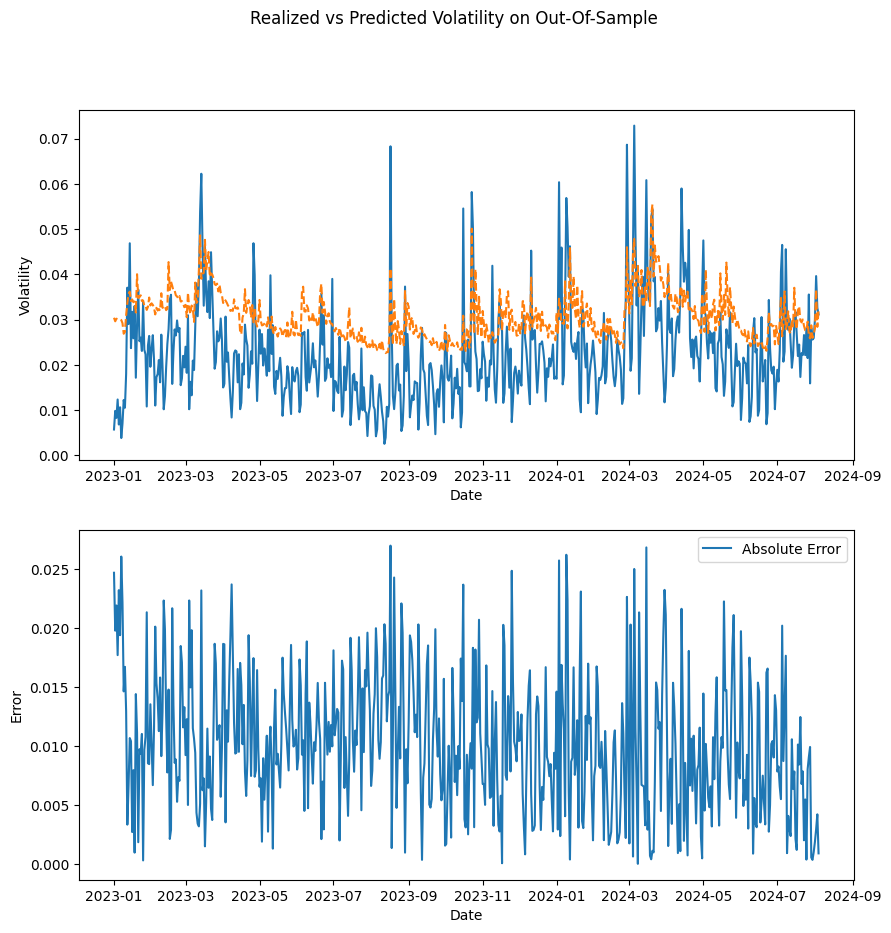

In [20]:
# Plot the actual vs predicted volatility
fig, ax = plt.subplots(2, 1, figsize=(10,10))
ax[0].plot(test_df.index, test_df['Realized_Volatility'], label='Realized Volatility')
ax[0].plot(test_df.index, test_df['Predicted_Volatility'], label='Predicted Volatility', linestyle='--')
ax[1].plot(test_df.index, (test_df['Realized_Volatility'] - test_df['Predicted_Volatility']).abs(), label='Absolute Error')
fig.suptitle('Realized vs Predicted Volatility on Out-Of-Sample')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Volatility')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Error')
plt.legend()
plt.show()

### Save Performance on CSV File

We’re almost there - the last step is to format predictions and realised volatility with exact timestamps. This is where Quanted's tech brings it all together, offering a glimpse into a new level of performance accuracy. [Want to see how](https://www.quanted.com/book-a-demo)?

In [21]:
# format data into expected format and store final CSV file
performance_df = pd.concat([train_df, test_df])
performance_df["PredictionDT"] = performance_df.index.strftime("%d/%m/%Y %H:%M:%S +00:00")
performance_df["PredictedValue"] = performance_df["Predicted_Volatility"]
performance_df["RealValue"] = performance_df["Realized_Volatility"]

performance_df[["PredictionDT", "PredictedValue", "RealValue"]].to_csv("QuantModelReport.csv", index=False)